## Imports

In [181]:
import time
import random
import pandas as pd
import math

%load_ext autoreload
%autoreload 2
%reload_ext autoreload
%env CUDA_VISIBLE_DEVICES=0,1
import os, sys
import time
import glob as glob

sys.path.insert(0, '..')
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import lib
import torch, torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import MinMaxScaler
import random
from pickle import dump, load

device = 'cuda' if torch.cuda.is_available() else 'cpu'
#device = 'cpu'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
env: CUDA_VISIBLE_DEVICES=0,1


## Make sure you have a GPU to evaluate
The energy and latency models are trained using parallel data load on a GPU. Please make sure you have a GPU on your system to run this.

In [182]:
torch.cuda.is_available()

True

## Neural Network Specifications

Make sure you change the test_dataset_path to place where you have stored test models. For instance

In [183]:
test_dataset_path =r'C:\Users\USER\workspace\Augur\dataset\torchvision_models\profiled'

files_wildcard = "*.csv"
files_path = os.path.join(test_dataset_path, files_wildcard)
file_list = glob.glob(files_path)

if(len(file_list)==0):
    print("No Files Found! Please copy the Neural Network Specs File at:",files_path )
    print("Layer Specification Format:")
    print("[kx,ifmx,ifmy,zin,zout,stride, padding, groups]")
    sys.exit()
    
print("The Following Neural Network Topologies Specifications are available:")
for each_file in file_list:
    print(os.path.basename(each_file))

The Following Neural Network Topologies Specifications are available:
mnasnet_conv_layers.csv
mobilenetv2_conv_layers.csv
resnet18_conv_layers.csv
ResNet50_conv_layers.csv
resnext_conv_layers.csv
squeezenet_conv_layers.csv
wide_resnet_50_conv_layers.csv


## Define The Energy Model

In [184]:
# Number of features in input vector
# [kx,ifmx,ifmy,zin,zout,stride, padding, groups]
in_features = 8
energy_model = nn.Sequential(
    lib.DenseBlock(in_features, 128, num_layers=6, tree_dim=3, depth=8, flatten_output=False,
                   choice_function=lib.entmax15, bin_function=lib.entmoid15),
    lib.Lambda(lambda x: x[..., 0].mean(dim=-1)),  # average first channels of every tree

).to(device)
    
#if torch.cuda.device_count() > 1:


trainer_energy = lib.Trainer(model=energy_model, loss_function=F.mse_loss)

energy_model = nn.DataParallel(energy_model)
ckpt_path = r"C:\Users\USER\workspace\Augur\dataset\models\energy\checkpoint_best_mse.pth"

trainer_energy.load_checkpoint(path=ckpt_path)

<function mse_loss at 0x000002D4C1658C18>


Trainer(
  (model): Sequential(
    (0): DenseBlock(
      (0): ODST(in_features=8, num_trees=128, depth=8, tree_dim=3, flatten_output=True)
      (1): ODST(in_features=392, num_trees=128, depth=8, tree_dim=3, flatten_output=True)
      (2): ODST(in_features=776, num_trees=128, depth=8, tree_dim=3, flatten_output=True)
      (3): ODST(in_features=1160, num_trees=128, depth=8, tree_dim=3, flatten_output=True)
      (4): ODST(in_features=1544, num_trees=128, depth=8, tree_dim=3, flatten_output=True)
      (5): ODST(in_features=1928, num_trees=128, depth=8, tree_dim=3, flatten_output=True)
    )
    (1): Lambda()
  )
)

## Define the Latency Model

In [185]:
latency_model = nn.Sequential(
    lib.DenseBlock(in_features, 128, num_layers=6, tree_dim=3, depth=8, flatten_output=False,
                   choice_function=lib.entmax15, bin_function=lib.entmoid15),
    lib.Lambda(lambda x: x[..., 0].mean(dim=-1)),  # average first channels of every tree

).to(device)
    
#if torch.cuda.device_count() > 1:


trainer_latency = lib.Trainer(model=latency_model, loss_function=F.mse_loss)

latency_model = nn.DataParallel(latency_model)
ckpt_path = r"C:\Users\USER\workspace\Augur\dataset\models\latency\good_models\energy_model_jan_02.pth"

trainer_latency.load_checkpoint(path=ckpt_path)

<function mse_loss at 0x000002D4C1658C18>


Trainer(
  (model): Sequential(
    (0): DenseBlock(
      (0): ODST(in_features=8, num_trees=128, depth=8, tree_dim=3, flatten_output=True)
      (1): ODST(in_features=392, num_trees=128, depth=8, tree_dim=3, flatten_output=True)
      (2): ODST(in_features=776, num_trees=128, depth=8, tree_dim=3, flatten_output=True)
      (3): ODST(in_features=1160, num_trees=128, depth=8, tree_dim=3, flatten_output=True)
      (4): ODST(in_features=1544, num_trees=128, depth=8, tree_dim=3, flatten_output=True)
      (5): ODST(in_features=1928, num_trees=128, depth=8, tree_dim=3, flatten_output=True)
    )
    (1): Lambda()
  )
)

## Data Pre-Processing helper methods

In [186]:
def parse_each_layer(df):
    
    data = df.values
    
    # Split data into X and y (ground truth)
    X = data[:,0:8]
    y_latency = np.log10(data[:,8:9]) # Latency
    y_energy = np.log10(data[:,9:10]) # Energy
    
    return X,y_latency,y_energy
            

def read_samples(filename):
    df = pd.read_csv(filename)
    return df

## Run the Profilers

In [187]:
# counters for plotting results
x_test = []
y_test_energy = []
y_test_latency = []
pred_energy=[]
pred_latency=[]
net_latency_augur = []
net_energy_augur = []
net_latency_golden = []
net_energy_golden = []
error_dict_latency = {}
error_dict_energy = {}

for each_file in file_list:
    print(each_file)
    df = read_samples(each_file)
    
    X, y_latency, y_energy = parse_each_layer(df)
    
    # Run the profiler
    mse_e, pred_e, ground_e, error_e = trainer_energy.evaluate_mse_test(np.float32(X), np.float32(y_energy), device=device)
    mse_l, pred_l, ground_l, error_l = trainer_latency.evaluate_mse_test(np.float32(X), np.float32(y_latency), device=device)
    
    # for layer level stats
    for each in X:
        x_test.append(each)
    
    # Transform back to orignal units - Energy (pJ)
    pred_e_trans = (10.0 ** np.array(pred_e)) #* (1/500e3) 
    ground_e_trans = 10.0 ** np.array(ground_e)#*(1/500e3) 
    
    # Transform latency to orignal units Cycles and convert to ms (frequency of 500 MHz)
    
    pred_l_trans = (10.0 ** np.array(pred_l)) * (1/500e3) 
    ground_l_trans = 10.0 ** np.array(ground_l)*(1/500e3)
    
    for each in ground_e_trans:
        y_test_energy.append(each)
    
    for each in ground_l_trans:
        y_test_latency.append(each)
    
    for each in pred_e_trans:
        pred_energy.append(each)
        
    for each in pred_l_trans:
        pred_latency.append(each)
        
    
    print("Augur Predicted Energy (pJ):",np.sum(pred_e_trans))
    print("Internal Profiler Estimated Energy (pJ):",np.sum(ground_e_trans))
    print("Augur Predicted Latency (ms):",np.sum(pred_l_trans))
    print("Internal Profiler Latency (ms):",np.sum(ground_l_trans))
    
    # Latency
    net_latency_augur.append(np.sum(pred_l_trans))
    net_latency_golden.append(np.sum(ground_l_trans))
    error_dict_latency[os.path.basename(each_file)] = np.abs(error_l[0][0]).tolist()
    
    # Energy
    net_energy_augur.append(np.sum(pred_e_trans))
    net_energy_golden.append(np.sum(ground_e_trans))
    error_dict_energy[os.path.basename(each_file)] = np.abs(error_e[0][0]).tolist()
    
    print("Mean Latency Error:%0.5f"% np.mean(error_e))
    print("Median Latency Error:%0.5f"% np.median(error_e))
    print("Max Latency Error:%0.5f"% np.max(error_e))
    print("Min Latency Error:%0.5f"% np.min(error_e))
    
    print("Mean Energy Error:%0.5f"% np.mean(error_l))
    print("Median Energy Error:%0.5f"% np.median(error_l))
    print("Max Energy Error:%0.5f"% np.max(error_l))
    print("Min Energy Error:%0.5f"% np.min(error_l))
    
    
    # Plot correlation plot for Energy
    plt.plot(ground_e_trans.flatten(), ground_e_trans.flatten(), color='green', alpha=0.4)
    plt.scatter(ground_e_trans.flatten(), ground_e_trans.flatten(), color='green', alpha=0.4, label='Internal Profiler')
    plt.scatter(ground_e_trans, pred_e_trans, alpha=0.4, label = 'Augur Predicted')
    plt.xlabel("WhiteBox Profiler Energy (pJ)")
    plt.ylabel("Augur Energy (pJ)")
    plt.legend()
    test_filename = each_file + "_Energy.png"
    plt.savefig(test_filename)
    plt.close()
   
    # Plot correlation plot for Latency
    plt.plot(ground_l_trans.flatten(), ground_l_trans.flatten(), color='green', alpha=0.4)
    plt.scatter(ground_l_trans.flatten(), ground_l_trans.flatten(), color='green', alpha=0.4, label='Internal Profiler')
    plt.scatter(ground_l_trans, pred_l_trans, alpha=0.4, label = 'Augur Predicted')
    plt.xlabel("WhiteBox Profiler Latency (ms)")
    plt.ylabel("Augur Latency (ms)")
    plt.legend()
    test_filename = each_file + "_Latency.png"
    plt.savefig(test_filename)
    plt.close()
   
    

C:\Users\USER\workspace\Augur\dataset\torchvision_models\profiled\mnasnet_conv_layers.csv
Augur Predicted Energy (pJ): 140160450.0
Internal Profiler Estimated Energy (pJ): 163714780.0
Augur Predicted Latency (ms): 1.9272283
Internal Profiler Latency (ms): 2.195236
Mean Latency Error:1.01568
Median Latency Error:0.86995
Max Latency Error:18.72037
Min Latency Error:-14.09557
Mean Energy Error:1.40108
Median Energy Error:1.03041
Max Energy Error:23.01938
Min Energy Error:-27.69286
C:\Users\USER\workspace\Augur\dataset\torchvision_models\profiled\mobilenetv2_conv_layers.csv
Augur Predicted Energy (pJ): 134933310.0
Internal Profiler Estimated Energy (pJ): 135296110.0
Augur Predicted Latency (ms): 1.4904354
Internal Profiler Latency (ms): 1.6017041
Mean Latency Error:-0.19280
Median Latency Error:0.00174
Max Latency Error:19.80295
Min Latency Error:-24.51228
Mean Energy Error:0.02133
Median Energy Error:0.02005
Max Energy Error:23.23852
Min Energy Error:-28.95285
C:\Users\USER\workspace\Augu

## Plot the Latency error stats for each topologies

Name	Mean Error	Median Error
mnasnet_conv_layers.csv:	7.2014874293395845	6.686587810516357
Name	Mean Error	Median Error
mobilenetv2_conv_layers.csv:	12.656988354361786	13.039329528808594
Name	Mean Error	Median Error
resnet18_conv_layers.csv:	11.77985902679594	10.051133155822754
Name	Mean Error	Median Error
ResNet50_conv_layers.csv:	5.809617248177529	5.195658564567566
Name	Mean Error	Median Error
resnext_conv_layers.csv:	6.1822785179202375	4.079943776130676
Name	Mean Error	Median Error
squeezenet_conv_layers.csv:	9.874387154579162	10.962448120117188
Name	Mean Error	Median Error
wide_resnet_50_conv_layers.csv:	6.518821481901866	4.390826106071472
Average Error in Latency across topologiesL: 8.574777030439444


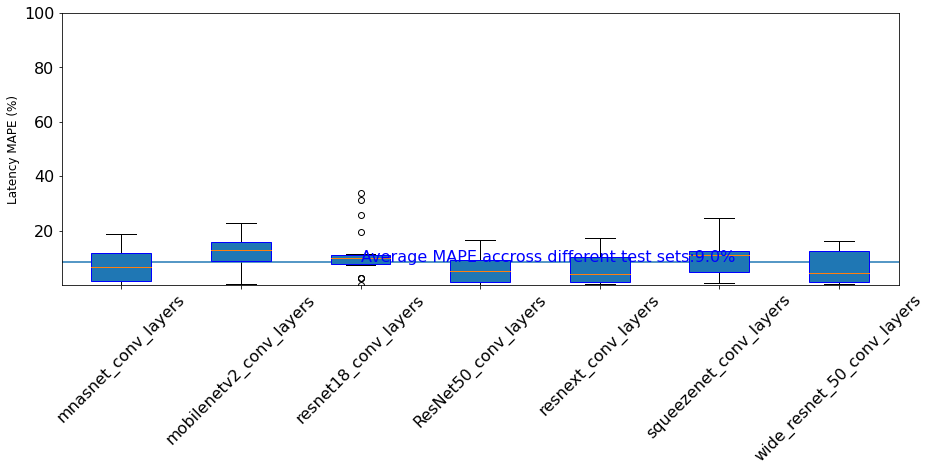

In [188]:
import matplotlib
matplotlib.rcParams['font.size'] = 12
mape = []
for k in error_dict_latency:
    mape.append(np.mean(error_dict_latency[k]))
    print("Name\t"+"Mean Error\t" +"Median Error")
    print(k + ":\t"+str(np.mean(error_dict_latency[k]))+"\t" +str(str(np.median(error_dict_latency[k]))))
print("Average Error in Latency across topologiesL:",np.mean(mape))

fb_nn_arcs_errors_latency = []
x_labels=[]

for k in error_dict_latency:
    x_labels.append(k.replace("bbox_conv_layers_energy_dataset_", "").split(".")[0])
    
for k in error_dict_latency:
    fb_nn_arcs_errors_latency.append(error_dict_latency[k])

fig = plt.figure(1, figsize=(15,5))

ax = fig.add_subplot(111)



ax.boxplot(fb_nn_arcs_errors_latency, boxprops=dict(color="blue", ), patch_artist=True)
ax.set_xticklabels(x_labels)
plt.tick_params(axis="both", which="major", labelsize=16)

plt.ylim(0.1,100)
plt.ylabel("Latency MAPE (%)")
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
plt.xticks(rotation=45)
plt.axhline(np.mean(mape))
plt.text(3,1*np.mean(mape), "Average MAPE accross different test sets:{}%".format(np.ceil(np.mean(mape))), fontsize=16, color='b')
plt.show()

## Plot Energy Error for each topologies

Name	Mean Error	Median Error
mnasnet_conv_layers.csv:	6.315302476670374	5.3614325523376465
Name	Mean Error	Median Error
mobilenetv2_conv_layers.csv:	11.601526141242713	12.13379955291748
Name	Mean Error	Median Error
resnet18_conv_layers.csv:	10.205916796859942	7.592199325561523
Name	Mean Error	Median Error
ResNet50_conv_layers.csv:	2.029456475675106	1.9729679226875305
Name	Mean Error	Median Error
resnext_conv_layers.csv:	4.837115744128823	3.4889144897460938
Name	Mean Error	Median Error
squeezenet_conv_layers.csv:	8.698653315901756	8.864314079284668
Name	Mean Error	Median Error
wide_resnet_50_conv_layers.csv:	4.002551067477236	3.4889144897460938
Average Error in Energy across topologiesL: 6.81293171685085


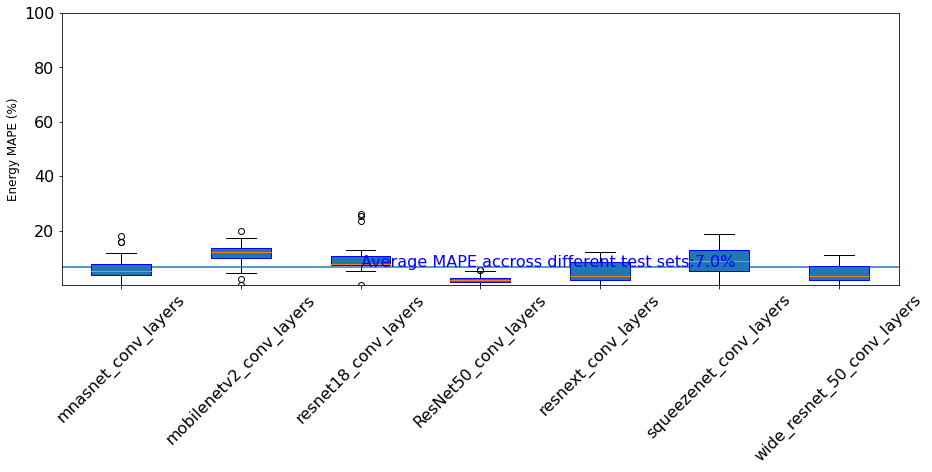

In [189]:
mape = []
for k in error_dict_energy:
    mape.append(np.mean(error_dict_energy[k]))
    print("Name\t"+"Mean Error\t" +"Median Error")
    print(k + ":\t"+str(np.mean(error_dict_energy[k]))+"\t" +str(str(np.median(error_dict_energy[k]))))
print("Average Error in Energy across topologiesL:",np.mean(mape))

fb_nn_arcs_errors_energy = []
x_labels=[]

for k in error_dict_energy:
    x_labels.append(k.replace("bbox_conv_layers_energy_dataset_", "").split(".")[0])
    
for k in error_dict_energy:
    fb_nn_arcs_errors_energy.append(error_dict_energy[k])

fig = plt.figure(1, figsize=(15,5))

ax = fig.add_subplot(111)



ax.boxplot(fb_nn_arcs_errors_energy, boxprops=dict(color="blue", ), patch_artist=True)
ax.set_xticklabels(x_labels)
plt.tick_params(axis="both", which="major", labelsize=16)

plt.ylim(0.1,100)
plt.ylabel("Energy MAPE (%)")
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
plt.xticks(rotation=45)
plt.axhline(np.mean(mape))
plt.text(3,1*np.mean(mape), "Average MAPE accross different test sets:{}%".format(np.ceil(np.mean(mape))), fontsize=16, color='b')
plt.show()